# Backtesting trading strategy combining Renko charts with MACD  

In [2]:
import numpy as np
import pandas as pd
from stocktrends import Renko
import statsmodels.api as sm
from alpha_vantage.timeseries import TimeSeries
import copy

In [3]:
# Not show warnings in the outputs
import warnings
warnings.filterwarnings("ignore")

#### The function MACD below calculates the Moving Average Convergence Divergence (MACD) indicator based on closing prices. MACD is a popular technical indicator used in trading that shows the relationship between 2 moving averages of the price of a financial asset. 

In [4]:


def MACD(DF, a, b, c):
    
    ''' Function to calculate MACD:
        DF: A DataFrame containing stock data, specifically the "Adj Close" (adjusted close prices) column.
        a: the fast Exponential Moving Average (EMA) which is typically equal to 12
        b: the slow EMA which is typically equal to 26
        c: the Signal line which is typically equal to 9 '''
   
    df = DF.copy()
    
    # The fucntion ewm() gives actually the EMA calculation
    df["EMA_Fast"] = df["Adj Close"].ewm(span = a, min_periods = a).mean()
    df["EMA_Slow"] = df["Adj Close"].ewm(span = b, min_periods = b).mean()
    df["MACD"] = df["EMA_Fast"] - df["EMA_Slow"]
    
    # The Signal line is the EMA of the MACD line over c periods
    # The Signal line will be used later to generate buy or sell signals based on crossovers with the MACD line.
    df["Signal"] = df["MACD"].ewm(span = c, min_periods = c).mean()
    
    # This line removes the beginning lines of the dataset for which the indicators are not calculated yet
    df.dropna(inplace = True)
    
    return (df["MACD"], df["Signal"])

def ATR(DF, n):
    
    '''Function to calculate the Average True Range (ATR) taking in two arguments:
       DF and n (the period for calculating the ATR)'''
    
    df = DF.copy()
    
    # H-L (High-Low): The difference between the highest and lowest prices of the day. This is the basic range for the day.
    df['H-L'] = abs(df['High'] - df['Low'])
    
    # H-PC (High-Previous Close): The difference between the highest price of the day and the adjusted close price 
    # from the previous day.
    df['H-PC'] = abs(df['High'] - df['Adj Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Adj Close'].shift(1))
    
    # True Range is the highest among all the 3 ranges computed above for each day
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis = 1,skipna = False)
    
    # Average True Range is the mean of True range over n periods
    df['ATR'] = df['TR'].rolling(n).mean()
    
    df2 = df.drop(['H-L','H-PC','L-PC'], axis = 1)
    
    return df2

In [5]:
def slope(ser, n):
    
    '''Function to calculate the slope of n consecutive points on a plot that takes in two arguments:
       ser: A series of data points
       n: The number of consecutive points to consider in each calculation window.'''
    
    # Initializing a list called slopes with n-1 zero values. These serve as placeholders for the initial data points,
    # for which a slope cannot be calculated due to the lack of prior points.
    slopes = [i * 0 for i in range(n - 1)]
    
    # Iterating through to the end of ser, so each loop step considers a new subset of n data points.
    for i in range(n, len(ser) + 1):
        
        # Extracts a slice of n points from ser starting from i - n to i, which represents the current window of data points
        y = ser[i - n : i]
        
        # Creating the x-axis values and scaling both x and y
        x = np.array(range(n))
        y_scaled = (y - y.min()) / (y.max() - y.min())
        x_scaled = (x - x.min()) / (x.max() - x.min())
        
        # Adding a constant and building the linear regression model
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        
        slopes.append(results.params[-1])
        
    # Calculating the angle of the slopes    
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    
    # Returns an array of the calculated slope angles in degrees for each window of n points.
    return np.array(slope_angle)

def renko_DF(DF):
    
    ''' Function that converts OHLC (Open, High, Low, Close) data into a Renko chart format using Renko bricks, 
        which is used in technical analysis to display price movement trends while filtering out minor price fluctuations.'''
    
    df = DF.copy()
    df.reset_index(inplace = True)
    
    # Selects only the first six columns
    df = df.iloc[:,[0,1,2,3,4,5]]
    
    df.columns = ["date","open","high","low","close","volume"]
    
    # Creates an instance of a Renko object 
    df2 = Renko(df)
    
    # Sets the brick size, a critical value in Renko charts, which determines the price movement threshold 
    # for forming a new brick. Sets the brick size to either 0.5 or the latest 120-day ATR (Average True Range) value, 
    # whichever is larger. This helps ensure that bricks are sized appropriately based on recent volatility.
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    
    # Retrieves the OHLC data transformed into Renko format.
    renko_df = df2.get_ohlc_data()
    
    # Creates a new column bar_num that assigns: 1 for an uptrend, -1 for a downtrend, 0 if there’s no trend direction.
    renko_df["bar_num"] = np.where(renko_df["uptrend"] == True,1,np.where(renko_df["uptrend"] == False,-1,0))
    
    # Iterates through the bar_num column to create cumulative bar numbers based on consecutive trends:
    for i in range(1, len(renko_df["bar_num"])):
        if renko_df["bar_num"][i] > 0 and renko_df["bar_num"][i - 1] > 0:
            renko_df["bar_num"][i] += renko_df["bar_num"][i - 1]
        elif renko_df["bar_num"][i] < 0 and renko_df["bar_num"][i - 1] < 0:
            renko_df["bar_num"][i] += renko_df["bar_num"][i - 1]
    
    # Removes duplicate rows based on the date column, keeping only the last occurrence of each date. 
    # This is useful if multiple Renko bricks are created on the same date.
    renko_df.drop_duplicates(subset = "date",keep = "last",inplace = True)
    
    return renko_df

In [6]:
def CAGR(DF):
    
    '''Function to calculate the Cumulative Annual Growth Rate of a trading strategy. CAGR is a measure used 
       to indicate the mean annual growth rate of an investment over a specified period, assuming the profits 
       were reinvested at the end of each period.'''
    
    df = DF.copy()
    df["cum_return"] = (1 + df["Ret"]).cumprod()
    
    # n represents the period length in years. There are 78 periods of 5 mn in a standard trading and 
    # 252 trading days in a typical year.
    n = len(df) / (252 * 78)
    
    # This gives the annual growth rate
    CAGR = (df["cum_return"].tolist()[-1]) ** (1 / n) - 1
    
    return CAGR

def volatility(DF):
    
    "Function to calculate annualized volatility of a trading strategy"
    
    df = DF.copy()
    
    # This gives the annualized volatility
    vol = df["Ret"].std() * np.sqrt(252 * 78)
    
    return vol

def sharpe(DF, rf):
    
    "Function to calculate sharpe ratio ; rf is the risk free rate"
    
    df = DF.copy()
    sr = (CAGR(df) - rf) / volatility(df)
    
    return sr

def max_dd(DF):
    
    '''Function to calculate Maximum drawdown which is a measure of the largest peak-to-trough 
       decline in an investment or trading strategy, expressed as a percentage. It’s a key risk metric as it shows 
       the worst potential loss an investor might face during the investment period.'''
    
    df = DF.copy()
    df["cum_return"] = (1 + df["Ret"]).cumprod()
    
    # Calculates the cumulative maximum value of cumulative returns up to each point in time.
    df["cum_roll_max"] = df["cum_return"].cummax()
    
    # Calculates the drawdown at each point in time by subtracting the cumulative return from the cumulative maximum.
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    
    df["drawdown_pct"] = df["drawdown"] / df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    
    return max_dd

# Dowloading data

In [7]:

# Download historical data for specific stocks. The data is pulled using the Alpha Vantage API and stored 
# in a dictionary for further use.

tickers = ["MSFT", "AAPL", "AMZN", "INTC", "CSCO"]

# Dictionary with ohlc value for each stock 
ohlc_intraday = {}

key_path = "C:\\Users\\flore\\key.txt"

# TimeSeries Instance: TimeSeries is an object from the alpha_vantage library that connects to Alpha Vantage API.
# key = open(key_path,'r').read() reads the API key from the file specified by key_path.
# output_format = 'pandas' specifies that the API should return data in the form of a Pandas DataFrame.
ts = TimeSeries(key = open(key_path,'r').read(), output_format = 'pandas')

attempt = 0 # Initializing passthrough variable
drop = [] # Initializing list to store tickers whose close price was successfully extracted

# This loop will run until either all tickers have been successfully fetched or the maximum retry attempts have been reached.
while len(tickers) != 0 and attempt <= 5:
    
    # This line updates the tickers list to include only those tickers that are not in the drop list
    tickers = [j for j in tickers if j not in drop]
    
    for i in range(len(tickers)):
        try:
            # Attempts to fetch 5-minute interval data for the given ticker using the Alpha Vantage API.
            ohlc_intraday[tickers[i]] = ts.get_intraday(symbol = tickers[i],interval = '5min', outputsize = 'full')[0]
            
            ohlc_intraday[tickers[i]].columns = ["Open","High","Low","Adj Close","Volume"]
            
            # If the data fetch is successful, the ticker is added to drop to avoid re-fetching.
            drop.append(tickers[i])   
            
        except:
            print(tickers[i]," :failed to fetch data...retrying")
            continue
            
    attempt += 1

# Redefine tickers variable after removing any tickers with corrupted data 
tickers = ohlc_intraday.keys() 

In [8]:
tickers

dict_keys(['MSFT', 'AAPL', 'AMZN', 'INTC', 'CSCO'])

In [23]:
# Having the dates order switched from oldest to newest dates'
for key in ohlc_intraday:
    ohlc_intraday[key] = ohlc_intraday[key].iloc[::-1]

# Displaying the first key-value pair
first_key = next(iter(ohlc_intraday))  # Get the first key
first_pair = {first_key: ohlc_intraday[first_key]}  # Create a dictionary with the first key-value pair

first_pair

{'MSFT':                          Open      High       Low  Adj Close   Volume
 date                                                                 
 2024-10-31 04:00:00  413.7682  416.6125  412.3710   414.6664  27873.0
 2024-10-31 04:05:00  414.7762  415.6444  414.2672   415.1654  15548.0
 2024-10-31 04:10:00  415.1754  415.9837  415.1654   415.9837  11047.0
 2024-10-31 04:15:00  415.8440  417.4109  415.8440   417.4109  15847.0
 2024-10-31 04:20:00  417.4109  417.4109  415.6644   416.2133  12958.0
 ...                       ...       ...       ...        ...      ...
 2024-11-29 16:35:00  422.8850  423.1000  422.6700   422.8600    286.0
 2024-11-29 16:40:00  423.0000  423.1000  422.7000   423.0000    537.0
 2024-11-29 16:45:00  422.9050  423.1000  422.7000   422.9750    478.0
 2024-11-29 16:50:00  423.0300  423.1100  422.7000   423.0300     69.0
 2024-11-29 16:55:00  423.0350  423.1387  422.7000   422.8500    424.0
 
 [3996 rows x 5 columns]}

# Backtesting strategy

In [10]:
# Merging Renko data with OHLC data for each ticker

# A dictionary to store the merged OHLC and Renko data for each ticker
ohlc_renko = {}

# A deep copy of ohlc_intraday, which presumably contains the OHLC data for each ticker
df = copy.deepcopy(ohlc_intraday)

# A dictionary to store trading signals for each ticker. Initially, this dictionary is empty, 
# and the signal values are defined later.
tickers_signal = {}

# A dictionary to store the returns of each ticker.
tickers_ret = {}

# tickers = list(ohlc_intraday.keys())[:1]

for ticker in tickers:
    
    print("merging for ",ticker)
    
    # This function converts OHLC (Open, High, Low, Close) data into a Renko chart format (Renko bricks)
    renko = renko_DF(df[ticker])
    print(renko)
    
    # Renaming the columns of renko
    renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
    
    df[ticker]["Date"] = df[ticker].index
    print(df[ticker])
    
    # Merges the OHLC data with the Renko data based on the "Date" column, using an outer join to 
    # retain all dates in both datasets
    ohlc_renko[ticker] = df[ticker].merge(renko.loc[:,["Date","bar_num"]],how = "outer",on = "Date")
    
    ohlc_renko[ticker]["bar_num"].fillna(method ='ffill',inplace = True)
    
    # Adding MACD, MACD's slope, MACD Signal line and MACD Signal line's slope
    ohlc_renko[ticker]["macd"] = MACD(ohlc_renko[ticker], 12, 26, 9)[0]
    ohlc_renko[ticker]["macd_sig"] = MACD(ohlc_renko[ticker], 12, 26, 9)[1]
    ohlc_renko[ticker]["macd_slope"] = slope(ohlc_renko[ticker]["macd"],5)
    ohlc_renko[ticker]["macd_sig_slope"] = slope(ohlc_renko[ticker]["macd_sig"],5)
    
    print(ohlc_renko[ticker])
    
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

merging for  MSFT
                   date   open   high    low  close  uptrend  bar_num
0   2024-10-31 04:00:00  412.0  414.0  412.0  414.0     True        1
1   2024-10-31 04:15:00  414.0  416.0  414.0  416.0     True        2
2   2024-10-31 08:20:00  416.0  418.0  416.0  418.0     True        3
5   2024-10-31 09:30:00  412.0  412.0  410.0  410.0    False       -3
6   2024-10-31 10:20:00  410.0  410.0  408.0  408.0    False       -4
..                  ...    ...    ...    ...    ...      ...      ...
135 2024-11-26 15:25:00  426.0  428.0  426.0  428.0     True       13
136 2024-11-27 11:10:00  426.0  426.0  424.0  424.0    False       -1
137 2024-11-27 16:00:00  424.0  424.0  422.0  422.0    False       -2
138 2024-11-29 09:30:00  422.0  422.0  420.0  420.0    False       -3
139 2024-11-29 12:15:00  422.0  424.0  422.0  424.0     True        1

[74 rows x 7 columns]
                         Open      High       Low  Adj Close   Volume  \
date                                          

                   date   open   high    low  close  uptrend  bar_num
0   2024-10-31 04:00:00  189.0  190.0  189.0  190.0     True        1
1   2024-10-31 07:50:00  190.0  191.0  190.0  191.0     True        2
2   2024-10-31 09:45:00  190.0  190.0  189.0  189.0    False       -1
3   2024-10-31 10:25:00  189.0  189.0  188.0  188.0    False       -2
4   2024-10-31 11:00:00  188.0  188.0  187.0  187.0    False       -3
..                  ...    ...    ...    ...    ...      ...      ...
108 2024-11-26 16:40:00  207.0  208.0  207.0  208.0     True       10
109 2024-11-27 09:50:00  207.0  207.0  206.0  206.0    False       -1
110 2024-11-29 09:30:00  206.0  206.0  205.0  205.0    False       -2
111 2024-11-29 12:15:00  206.0  207.0  206.0  207.0     True        1
112 2024-11-29 12:50:00  207.0  208.0  207.0  208.0     True        2

[100 rows x 7 columns]
                         Open    High     Low  Adj Close   Volume  \
date                                                               

                  date  open  high   low close  uptrend  bar_num
0  2024-10-31 04:00:00  55.0  55.5  55.0  55.5     True        1
1  2024-10-31 16:20:00  55.0  55.0  54.5  54.5    False       -1
2  2024-11-01 10:30:00  55.0  55.5  55.0  55.5     True        1
3  2024-11-04 16:45:00  55.5  56.0  55.5  56.0     True        2
4  2024-11-05 19:50:00  56.0  56.5  56.0  56.5     True        3
5  2024-11-06 06:35:00  56.5  57.0  56.5  57.0     True        4
6  2024-11-06 09:35:00  57.0  57.5  57.0  57.5     True        5
7  2024-11-06 13:55:00  57.5  58.0  57.5  58.0     True        6
9  2024-11-11 05:00:00  58.5  59.0  58.5  59.0     True        8
10 2024-11-13 16:00:00  59.0  59.5  59.0  59.5     True        9
11 2024-11-13 16:30:00  59.0  59.0  58.5  58.5    False       -1
12 2024-11-13 17:45:00  58.5  58.5  58.0  58.0    False       -2
13 2024-11-13 19:15:00  58.0  58.0  57.5  57.5    False       -3
14 2024-11-14 04:10:00  57.5  57.5  57.0  57.0    False       -4
16 2024-11-14 04:40:00  5

In [11]:
ohlc_renko['MSFT']

,Open,High,Low,Adj Close,Volume,Date,bar_num,macd,macd_sig,macd_slope,macd_sig_slope
0,413.7682,416.6125,412.3710,414.6664,27873.0,2024-10-31 04:00:00,1.0,NaN,NaN,0.000000,0.000000
1,414.7762,415.6444,414.2672,415.1654,15548.0,2024-10-31 04:05:00,1.0,NaN,NaN,0.000000,0.000000
2,415.1754,415.9837,415.1654,415.9837,11047.0,2024-10-31 04:10:00,1.0,NaN,NaN,0.000000,0.000000
3,415.8440,417.4109,415.8440,417.4109,15847.0,2024-10-31 04:15:00,2.0,NaN,NaN,0.000000,0.000000
4,417.4109,417.4109,415.6644,416.2133,12958.0,2024-10-31 04:20:00,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3991,422.8850,423.1000,422.6700,422.8600,286.0,2024-11-29 16:35:00,1.0,-0.099628,-0.103075,46.060539,-42.352486
3992,423.0000,423.1000,422.7000,423.0000,537.0,2024-11-29 16:40:00,1.0,-0.083441,-0.099148,44.348608,9.730942
3993,422.9050,423.1000,422.7000,422.9750,478.0,2024-11-29 16:45:00,1.0,-0.071802,-0.093679,44.334872,44.247745
3994,423.0300,423.1100,422.7000,423.0300,69.0,2024-11-29 16:50:00,1.0,-0.057478,-0.086439,46.020614,45.420608


In [12]:
renko

,Date,open,high,low,close,uptrend,bar_num
0,2024-10-31 04:00:00,55.0,55.5,55.0,55.5,True,1
1,2024-10-31 16:20:00,55.0,55.0,54.5,54.5,False,-1
2,2024-11-01 10:30:00,55.0,55.5,55.0,55.5,True,1
3,2024-11-04 16:45:00,55.5,56.0,55.5,56.0,True,2
4,2024-11-05 19:50:00,56.0,56.5,56.0,56.5,True,3
5,2024-11-06 06:35:00,56.5,57.0,56.5,57.0,True,4
6,2024-11-06 09:35:00,57.0,57.5,57.0,57.5,True,5
7,2024-11-06 13:55:00,57.5,58.0,57.5,58.0,True,6
9,2024-11-11 05:00:00,58.5,59.0,58.5,59.0,True,8
10,2024-11-13 16:00:00,59.0,59.5,59.0,59.5,True,9


In [13]:
# Identifying trading signals (Buy, Sell, or No Signal) for multiple tickers based on Renko 
# and MACD data and calculates daily returns based on those signals.      

a = 2

for ticker in tickers:
    print("calculating daily returns for ",ticker)
    
    # An inner loop iterates over each row in the OHLC (Open, High, Low, Close) intraday data for the current ticker, 
    # allowing access to each row of the DataFrame by index i
    for i in range(len(ohlc_intraday[ticker])):
        
        # When there is no signal
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if i > 0:
                
            # Buy Signal: bar_num is >= 2, MACD is above the signal line, and MACD slope is higher than signal line slope
                if ohlc_renko[ticker]["bar_num"][i] >= a and ohlc_renko[ticker]["macd"][i] > ohlc_renko[ticker]["macd_sig"][i]\
                and ohlc_renko[ticker]["macd_slope"][i] > ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Buy"
                    
            # Sell Signal: bar_num is <= -2, MACD is below the signal line, and the MACD slope is lower than signal line slope        
                elif ohlc_renko[ticker]["bar_num"][i] <= -a and ohlc_renko[ticker]["macd"][i] < ohlc_renko[ticker]["macd_sig"]\
                [i] and ohlc_renko[ticker]["macd_slope"][i] < ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Sell"
        
        # When there is already a Buy Signal
        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i] / ohlc_renko[ticker]["Adj Close"][i-1])-1)
            if i > 0:
                
            # Switch to Sell: bar_num is <= -2, MACD is below the signal line and MACD slope is lower than signal line slope
                if ohlc_renko[ticker]["bar_num"][i] <= -a and ohlc_renko[ticker]["macd"][i] < ohlc_renko[ticker]["macd_sig"][i]\
                and ohlc_renko[ticker]["macd_slope"][i] < ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Sell"
                    
            # Switch to No Signal: MACD is below the signal line and MACD slope is lower than signal line slope
                elif ohlc_renko[ticker]["macd"][i] < ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]\
                < ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = ""
        
        # When there is already a Sell Signal
        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i-1] / ohlc_renko[ticker]["Adj Close"][i])-1)
            if i > 0:
                
            # Switch to Buy: bar_num is >= 2, MACD is above the signal line, and MACD slope is higher than signal line slope
                if ohlc_renko[ticker]["bar_num"][i] >= a and ohlc_renko[ticker]["macd"][i] > ohlc_renko[ticker]["macd_sig"][i]\
                and ohlc_renko[ticker]["macd_slope"][i] > ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Buy"
                    
            # Switch to No Signal: MACD is above the signal line and MACD slope is higher than signal line slope       
                elif ohlc_renko[ticker]["macd"][i] > ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]\
                > ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = ""
                    
    ohlc_renko[ticker]["Ret"] = np.array(tickers_ret[ticker])
    print(ohlc_renko[ticker])

calculating daily returns for  MSFT
          Open      High       Low  Adj Close   Volume                Date  \
0     413.7682  416.6125  412.3710   414.6664  27873.0 2024-10-31 04:00:00   
1     414.7762  415.6444  414.2672   415.1654  15548.0 2024-10-31 04:05:00   
2     415.1754  415.9837  415.1654   415.9837  11047.0 2024-10-31 04:10:00   
3     415.8440  417.4109  415.8440   417.4109  15847.0 2024-10-31 04:15:00   
4     417.4109  417.4109  415.6644   416.2133  12958.0 2024-10-31 04:20:00   
...        ...       ...       ...        ...      ...                 ...   
3991  422.8850  423.1000  422.6700   422.8600    286.0 2024-11-29 16:35:00   
3992  423.0000  423.1000  422.7000   423.0000    537.0 2024-11-29 16:40:00   
3993  422.9050  423.1000  422.7000   422.9750    478.0 2024-11-29 16:45:00   
3994  423.0300  423.1100  422.7000   423.0300     69.0 2024-11-29 16:50:00   
3995  423.0350  423.1387  422.7000   422.8500    424.0 2024-11-29 16:55:00   

      bar_num      macd  ma

In [24]:
# Calculating overall strategy's KPIs
strategy_df = pd.DataFrame()

for ticker in tickers:
    
    strategy_df[ticker] = ohlc_renko[ticker]["Ret"]
strategy_df["Ret"] = strategy_df.mean(axis=1)

print(CAGR(strategy_df))
print(sharpe(strategy_df,0.025))
print(max_dd(strategy_df))

-0.42708286522381367
-5.41687489059208
0.1162347179513338


In [16]:
strategy_df.head()

,MSFT,AAPL,AMZN,INTC,CSCO,Ret
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

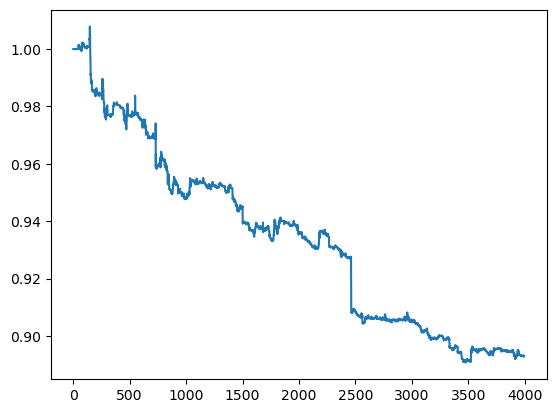

In [17]:
# Visualizing strategy returns over time
(1 + strategy_df["Ret"]).cumprod().plot()

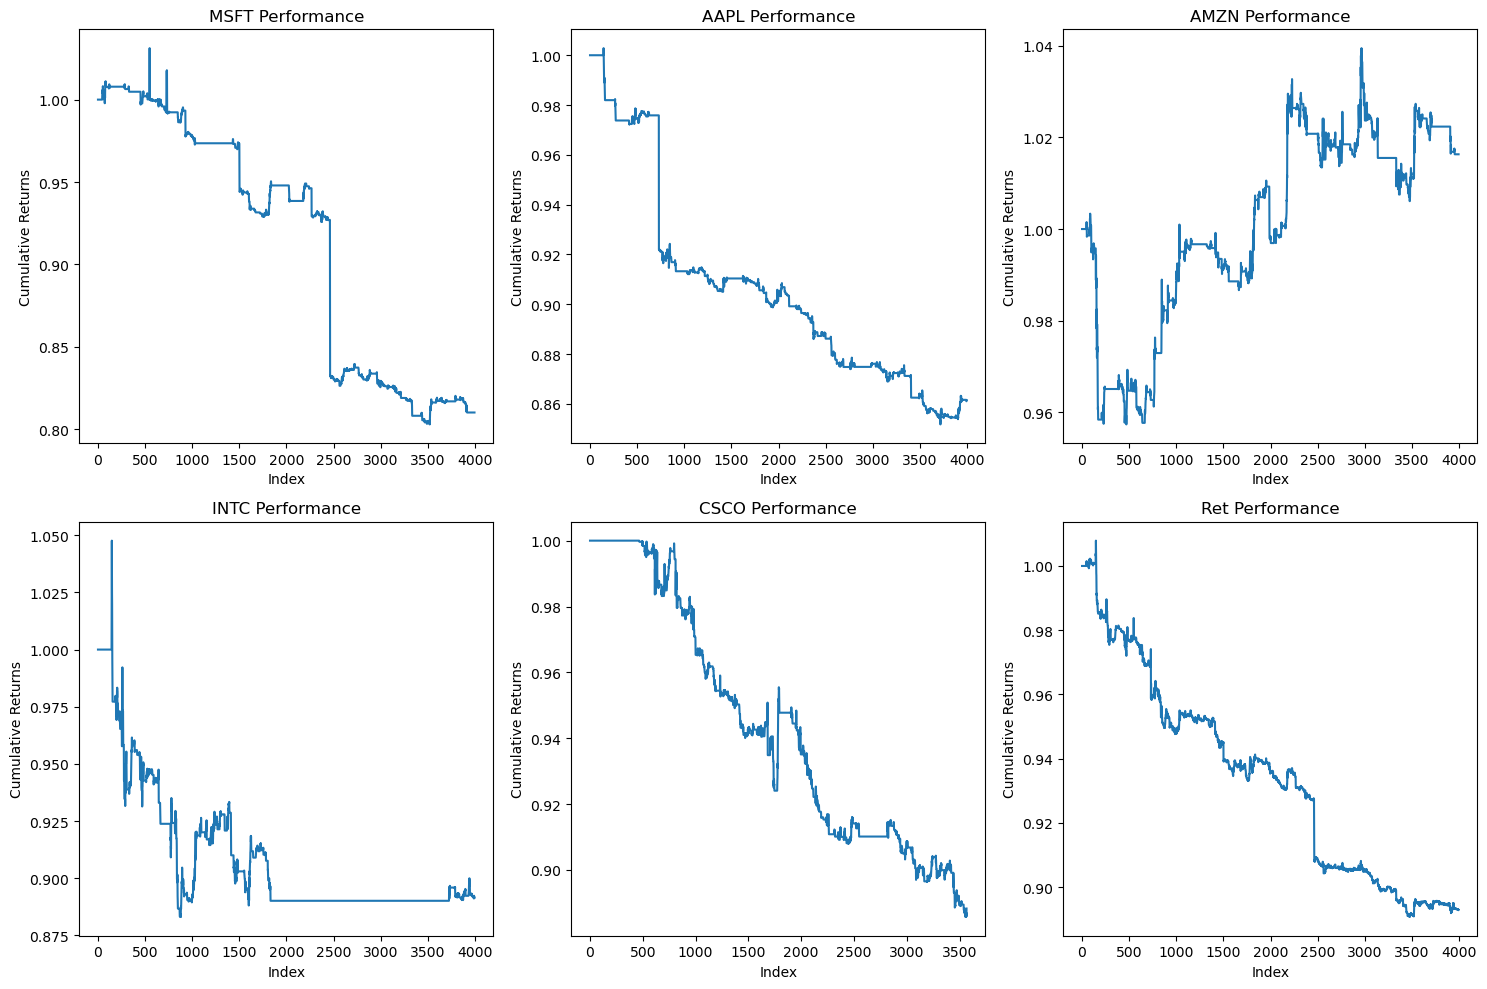

In [18]:
# Plotting the performance of each stock and the overall strategy performance

import matplotlib.pyplot as plt
import math

# Define the number of subplots needed
n_columns = len(strategy_df.columns)  # Number of columns in the DataFrame
n_cols_per_row = 3  # Set how many graphs per row
n_rows = math.ceil(n_columns / n_cols_per_row)  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols_per_row, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, column in enumerate(strategy_df.columns):
    # Plot each column
    (1 + strategy_df[column]).cumprod().plot(ax=axes[i])
    axes[i].set_title(f"{column} Performance")
    axes[i].set_xlabel("Index")
    axes[i].set_ylabel("Cumulative Returns")

# Hide any unused axes
for ax in axes[n_columns:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [19]:
# Calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  AMZN
calculating KPIs for  INTC
calculating KPIs for  CSCO


,Return,Sharpe Ratio,Max Drawdown
MSFT,-0.644847,-2.714423,0.221318
AAPL,-0.519789,-3.848426,0.150696
AMZN,0.082768,0.483966,0.045796
INTC,-0.431398,-2.154163,0.157115
CSCO,-0.479456,-3.672179,0.114247
